In [1]:
import torch
import torch.utils.cpp_extension
from pathlib import Path
import random
import triton
import triton.language as tl

In [2]:
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [3]:
def test_correctness(softmax_impl, repeats=100):
    for i in range(repeats):
        row = random.randint(1, 1024 * 32)
        cols = random.randint(1, 1024 * 32)
        a = torch.randn((row, cols), device="cuda", dtype=torch.float32)
        torch.testing.assert_close(softmax_impl(a), torch.nn.functional.softmax(a, dim=-1), msg=f"row = {row}, cols = {cols}")
    return softmax_impl

In [4]:
test_correctness(lambda a: torch.nn.functional.softmax(a, dim=-1))

<function __main__.<lambda>(a)>

In [5]:
def load_cuda_impl(file_name):
    cuda_src = Path(file_name).read_text()
    cpp_src = """
    torch::Tensor softmax(const torch::Tensor& x);
    """
    my = torch.utils.cpp_extension.load_inline(
        "my", cpp_src, cuda_src,
        functions=['softmax'], extra_cuda_cflags=['--ptxas-options=-v'], verbose=True,
    )
    return my.softmax

In [6]:
kernels = {}

In [7]:
def add_kernel(name, kernel):
    kernels[name] = kernel

In [8]:
add_kernel("Torch", torch.nn.functional.softmax)

## Naive

In [9]:
def naive_pytorch_softmax(x, dim=None):
    m = torch.max(x, dim=dim, keepdim=True)[0]
    e = torch.exp(x - m)
    s = torch.sum(e, dim=dim, keepdim=True)
    return e / s

In [10]:
add_kernel("Naive", test_correctness(lambda a: naive_pytorch_softmax(a, dim=-1)))

In [11]:
@torch.compile
def compiled_naive_pytorch_softmax(x, dim=None):
    return naive_pytorch_softmax(x, dim=dim)

In [12]:
add_kernel("CompiledNaive", test_correctness(lambda a: compiled_naive_pytorch_softmax(a, dim=-1)))

## CUDA

In [13]:
softmax1 = add_kernel("CUDA1", test_correctness(load_cuda_impl("softmax1.cu")))

Using /home/belevich/.cache/torch_extensions/py312_cu126 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/belevich/.cache/torch_extensions/py312_cu126/my/build.ninja...
/fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/utils/cpp_extension.py:2356: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module my...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=my -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/include -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /usr/local/cuda/include -isystem /fsxl/belevich/miniconda3/include/python3.12 -D_GLIBCXX_USE_CXX11_ABI=1 -fPIC -std=c++17 -c /home/belevich/.cache/torch_extensions/py312_cu126/my/main.cpp -o main.o 
[2/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=my -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/include -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/include/tor

Loading extension module my...


In [14]:
softmax2 = add_kernel("CUDA2", test_correctness(load_cuda_impl("softmax2.cu")))

Using /home/belevich/.cache/torch_extensions/py312_cu126 as PyTorch extensions root...
The input conditions for extension module my have changed. Bumping to version 1 and re-building as my_v1...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/belevich/.cache/torch_extensions/py312_cu126/my/build.ninja...
/fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/utils/cpp_extension.py:2356: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module my_v1...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=my_v1 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/include -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /usr/local/cuda/include -isystem /fsxl/belevich/miniconda3/include/python3.12 -D_GLIBCXX_USE_CXX11_ABI=1 -fPIC -std=c++17 -c /home/belevich/.cache/torch_extensions/py312_cu126/my/main.cpp -o main.o 
[2/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=my_v1 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/include -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/inclu

Loading extension module my_v1...


In [15]:
softmax2_shfl = add_kernel("CUDA2_SHFL", test_correctness(load_cuda_impl("softmax2_shfl.cu")))

Using /home/belevich/.cache/torch_extensions/py312_cu126 as PyTorch extensions root...
The input conditions for extension module my have changed. Bumping to version 2 and re-building as my_v2...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/belevich/.cache/torch_extensions/py312_cu126/my/build.ninja...
/fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/utils/cpp_extension.py:2356: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module my_v2...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=my_v2 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/include -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /usr/local/cuda/include -isystem /fsxl/belevich/miniconda3/include/python3.12 -D_GLIBCXX_USE_CXX11_ABI=1 -fPIC -std=c++17 -c /home/belevich/.cache/torch_extensions/py312_cu126/my/main.cpp -o main.o 
[2/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=my_v2 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/include -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/inclu

Loading extension module my_v2...


In [16]:
# softmax3 = add_kernel("CUDA3", test_correctness(load_cuda_impl("softmax3.cu")))

In [17]:
softmax3_shfl = add_kernel("CUDA3_SHFL", test_correctness(load_cuda_impl("softmax3_shfl.cu")))

Using /home/belevich/.cache/torch_extensions/py312_cu126 as PyTorch extensions root...
The input conditions for extension module my have changed. Bumping to version 3 and re-building as my_v3...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/belevich/.cache/torch_extensions/py312_cu126/my/build.ninja...
/fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/utils/cpp_extension.py:2356: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module my_v3...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=my_v3 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/include -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /usr/local/cuda/include -isystem /fsxl/belevich/miniconda3/include/python3.12 -D_GLIBCXX_USE_CXX11_ABI=1 -fPIC -std=c++17 -c /home/belevich/.cache/torch_extensions/py312_cu126/my/main.cpp -o main.o 
[2/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=my_v3 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/include -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/inclu

Loading extension module my_v3...


In [18]:
softmax5 = add_kernel("CUDA5", test_correctness(load_cuda_impl("softmax5.cu")))

Using /home/belevich/.cache/torch_extensions/py312_cu126 as PyTorch extensions root...
The input conditions for extension module my have changed. Bumping to version 4 and re-building as my_v4...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/belevich/.cache/torch_extensions/py312_cu126/my/build.ninja...
/fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/utils/cpp_extension.py:2356: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module my_v4...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=my_v4 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/include -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /usr/local/cuda/include -isystem /fsxl/belevich/miniconda3/include/python3.12 -D_GLIBCXX_USE_CXX11_ABI=1 -fPIC -std=c++17 -c /home/belevich/.cache/torch_extensions/py312_cu126/my/main.cpp -o main.o 
[2/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=my_v4 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/include -isystem /fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/inclu

Loading extension module my_v4...


## Triton

In [19]:
@triton.jit
def triton_softmax1_kernel(
    x,
    x_row_stride,
    y,
    y_row_stride,
    n_cols,
    block_size: tl.constexpr,
):
    row_idx = tl.program_id(0)
    x_row_start = x + row_idx * x_row_stride
    col_offsets = tl.arange(0, block_size)
    row_ptrs = x_row_start + col_offsets
    mask = col_offsets < n_cols
    row = tl.load(row_ptrs, mask=mask, other=float('-inf'))

    row_max = tl.max(row, axis=0)
    safe_row = row - row_max
    exp_row = tl.exp(safe_row)
    sum_row = tl.sum(exp_row, axis=0)
    y_row_start = y + row_idx * y_row_stride
    y_ptrs = y_row_start + col_offsets
    tl.store(y_ptrs, exp_row / sum_row, mask=mask)

def triton_softmax1(x: torch.Tensor) -> torch.Tensor:
    x_flatten = x.reshape(-1, x.size(-1))
    y = torch.empty_like(x_flatten)
    rows, cols = x_flatten.shape
    block_size = triton.next_power_of_2(cols)
    num_warps = 4
    if block_size > 2047:
        num_warps = 8
    elif block_size > 4095:
        num_warps = 16

    grid = (rows, )
    triton_softmax1_kernel[grid](x_flatten, x_flatten.stride(0), y, y.stride(0), cols, block_size, num_warps=num_warps)
    
    return y.view_as(x)

add_kernel("Triton1", test_correctness(triton_softmax1))

In [20]:
@triton.jit
def triton_softmax2_kernel(
    x,
    x_row_stride,
    y,
    y_row_stride,
    n_cols,
    block_size: tl.constexpr,
):
    row_idx = tl.program_id(0)
    x_row_start = x + row_idx * x_row_stride
    y_row_start = y + row_idx * y_row_stride
    offsets = tl.arange(0, block_size)
    row_max = tl.full((), -float("inf"), dtype=tl.float32)
    for b in range(0, (n_cols + block_size - 1) // block_size):
        idx = b * block_size + offsets
        mask = idx < n_cols
        x_vals = tl.load(x_row_start + idx, mask=mask)
        row_max = tl.maximum(row_max, tl.max(x_vals.to(tl.float32)))

    row_sum = tl.zeros((), dtype=tl.float32)
    for b in range(0, (n_cols + block_size - 1) // block_size):
        idx = b * block_size + offsets
        mask = idx < n_cols
        x_vals = tl.load(x_row_start + idx, mask=mask, other=-float("inf"))
        x_vals = tl.exp(x_vals - row_max)
        row_sum += tl.sum(x_vals)
        tl.store(y_row_start + idx, x_vals, mask=mask)

    for b in range(0, (n_cols + block_size - 1) // block_size):
        idx = b * block_size + offsets
        mask = idx < n_cols
        y_vals = tl.load(y_row_start + idx, mask=mask)
        y_vals /= row_sum
        tl.store(y_row_start + idx, y_vals, mask=mask)
    

def triton_softmax2(x: torch.Tensor) -> torch.Tensor:
    x_flatten = x.reshape(-1, x.size(-1))
    y = torch.empty_like(x_flatten)
    rows, cols = x_flatten.shape
    block_size = 1024 * 32
    num_warps = 4
    if block_size > 2047:
        num_warps = 8
    elif block_size > 4095:
        num_warps = 16
    grid = (rows,)
    triton_softmax2_kernel[grid](x_flatten, x_flatten.stride(0), y, y.stride(0), cols, block_size, num_warps=num_warps)
    return y.view_as(x)

add_kernel("Triton2", test_correctness(triton_softmax2))

In [21]:
@triton.jit
def triton_softmax3_kernel(
    x,
    x_row_stride,
    y,
    y_row_stride,
    n_cols,
    block_size: tl.constexpr,
):
    row_idx = tl.program_id(0)
    x_row_start = x + row_idx * x_row_stride
    y_row_start = y + row_idx * y_row_stride
    current_max = float('-inf')
    current_sum = 0.0
    
    for block_offset in tl.range(0, n_cols, block_size):
        col_offsets = block_offset + tl.arange(0, block_size)
        block = tl.load(x_row_start + col_offsets, mask=col_offsets < n_cols, other=float('-inf'))
        new_max = tl.maximum(current_max, tl.max(block))
        current_sum *= tl.exp(current_max - new_max)
        current_sum += tl.sum(tl.exp(block - new_max))
        current_max = new_max

    for block_offset in tl.range(0, n_cols, block_size):
        col_offsets = block_offset + tl.arange(0, block_size)
        block = tl.load(x_row_start + col_offsets, mask=col_offsets < n_cols, other=float('-inf'))
        tl.store(y_row_start + col_offsets, tl.exp(block - current_max) / current_sum, mask=col_offsets < n_cols)


def triton_softmax3(x: torch.Tensor) -> torch.Tensor:
    x_flatten = x.reshape(-1, x.size(-1))
    y = torch.empty_like(x_flatten)
    rows, cols = x_flatten.shape
    block_size = 32 * 1024
    num_warps = 32
    grid = (rows, )
    triton_softmax3_kernel[grid](x_flatten, x_flatten.stride(0), y, y.stride(0), cols, block_size, num_warps=num_warps)
    return y.view_as(x)

add_kernel("Triton3", test_correctness(triton_softmax3))

In [22]:
@triton.jit
def max_kernel(x, x_row_stride, max_values, n_cols, block_size: tl.constexpr):
    row_idx = tl.program_id(0)
    x_row_start = x + row_idx * x_row_stride

    max_value = tl.full((), float('-inf'), dtype=tl.float32)
    for block_offset in tl.range(0, n_cols, block_size):
        col_offsets = block_offset + tl.arange(0, block_size)
        block = tl.load(x_row_start + col_offsets, mask=col_offsets < n_cols, other=float('-inf'))
        max_value = tl.maximum(max_value, tl.max(block))
    
    tl.store(max_values + row_idx, max_value)

@triton.jit
def sum_kernel(x, x_row_stride, max_values, sum_values, n_cols, block_size: tl.constexpr):
    row_idx = tl.program_id(0)
    x_row_start = x + row_idx * x_row_stride

    max_value = tl.load(max_values + row_idx)

    sum_value = tl.full((), 0.0, dtype=tl.float32)
    for block_offset in tl.range(0, n_cols, block_size):
        col_offsets = block_offset + tl.arange(0, block_size)
        block = tl.load(x_row_start + col_offsets, mask=col_offsets < n_cols, other=float('-inf'))
        sum_value += tl.sum(tl.exp(block - max_value))
    
    tl.store(sum_values + row_idx, sum_value)
    
@triton.jit
def softmax_kernel_5(x, x_row_stride, max_values, sum_values, y, y_row_stride, n_cols, block_size: tl.constexpr):
    row_idx = tl.program_id(0)
    x_row_start = x + row_idx * x_row_stride
    y_row_start = y + row_idx * y_row_stride

    max_value = tl.load(max_values + row_idx)
    sum_value = tl.load(sum_values + row_idx)

    for block_offset in tl.range(0, n_cols, block_size):
        col_offsets = block_offset + tl.arange(0, block_size)
        block = tl.load(x_row_start + col_offsets, mask=col_offsets < n_cols, other=float('-inf'))
        tl.store(y_row_start + col_offsets, tl.exp(block - max_value) / sum_value, mask=col_offsets < n_cols)

def triton_softmax5(x: torch.Tensor) -> torch.Tensor:
    x_flatten = x.reshape(-1, x.size(-1))
    y = torch.empty_like(x_flatten)
    rows, cols = x_flatten.shape
    block_size = 64 * 1024
    num_warps = 32
    grid = (rows, )
    max_values = torch.empty(rows, device=x.device, dtype=x.dtype)
    max_kernel[grid](x_flatten, x_flatten.stride(0), max_values, cols, block_size, num_warps=num_warps)
    sum_values = torch.empty(rows, device=x.device, dtype=x.dtype)
    sum_kernel[grid](x_flatten, x_flatten.stride(0), max_values, sum_values, cols, block_size, num_warps=num_warps)
    softmax_kernel_5[grid](x_flatten, x_flatten.stride(0), max_values, sum_values, y, y.stride(0), cols, block_size, num_warps=num_warps)
    return y.view_as(x)

add_kernel("Triton5", test_correctness(triton_softmax5))

In [23]:
@triton.jit
def partial_max_value_kernel(X, partial_max, cols, BLOCK_SIZE: tl.constexpr):
    X = X.to(tl.pointer_type(tl.float32))
    partial_max = partial_max.to(tl.pointer_type(tl.float32))

    row = tl.program_id(0)
    pid = tl.program_id(1)

    col_offset = pid * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
    x = tl.load(X + row * cols + col_offset, mask=col_offset < cols, other=-float('inf'))
    local_max = tl.max(x, axis=0)
    tl.store(partial_max + row * BLOCK_SIZE + pid, local_max)


@triton.jit
def partial_exp_sum_value_kernel(X, partial_sum, global_max, cols, BLOCK_SIZE: tl.constexpr):
    X = X.to(tl.pointer_type(tl.float32))
    partial_sum = partial_sum.to(tl.pointer_type(tl.float32))
    global_max = global_max.to(tl.pointer_type(tl.float32))

    row = tl.program_id(0)
    pid = tl.program_id(1)

    col_offset = pid * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
    x = tl.load(X + row * cols + col_offset, mask=col_offset < cols, other=-float('inf'))
    gmax = tl.load(global_max + row)
    x = tl.exp(x - gmax)
    sum_value = tl.sum(x, axis=0)
    tl.store(partial_sum + row * BLOCK_SIZE + pid, sum_value)


@triton.jit
def normalize_kernel(X, Y, global_max, global_sum, cols, BLOCK_SIZE: tl.constexpr):
    X = X.to(tl.pointer_type(tl.float32))
    Y = Y.to(tl.pointer_type(tl.float32))
    global_max = global_max.to(tl.pointer_type(tl.float32))
    global_sum = global_sum.to(tl.pointer_type(tl.float32))

    row = tl.program_id(0)
    pid = tl.program_id(1)

    col_offset = pid * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
    x = tl.load(X + row * cols + col_offset, mask=col_offset < cols, other=-float('inf'))
    gmax = tl.load(global_max + row)
    gsum = tl.load(global_sum + row)
    y = tl.exp(x - gmax) / gsum
    tl.store(Y + row * cols + col_offset, y, mask=col_offset < cols)


@triton.jit
def get_max_value(partial_max, global_max, BLOCK_SIZE: tl.constexpr):
    partial_max = partial_max.to(tl.pointer_type(tl.float32))
    global_max = global_max.to(tl.pointer_type(tl.float32))

    row = tl.program_id(0)

    col_offset = tl.arange(0, BLOCK_SIZE)
    x = tl.load(partial_max + row * BLOCK_SIZE + col_offset)
    local_max = tl.max(x, axis=0)
    tl.store(global_max + row, local_max)
    

@triton.jit
def get_sum_value(partial_sum, global_sum, BLOCK_SIZE: tl.constexpr):
    partial_sum = partial_sum.to(tl.pointer_type(tl.float32))
    global_sum = global_sum.to(tl.pointer_type(tl.float32))

    row = tl.program_id(0)

    col_offset = tl.arange(0, BLOCK_SIZE)
    x = tl.load(partial_sum + row * BLOCK_SIZE + col_offset)
    tl.store(global_sum + row, tl.sum(x))
    

def cudaEmpty(num_elements:int):
    import ctypes
    cudart = ctypes.CDLL("libcudart.so")
    cudart.cudaMalloc.argtypes = [ctypes.POINTER(ctypes.c_void_p), ctypes.c_size_t]
    cudart.cudaMalloc.restype = ctypes.c_int
    ptr = ctypes.c_void_p()
    err = cudart.cudaMalloc(ctypes.byref(ptr), num_elements*4)
    if err != 0:
        raise RuntimeError(f"cudaMalloc failed, code {err}")
    return ptr.value

def cudaFree(ptr):
    import ctypes
    cudart = ctypes.CDLL("libcudart.so")
    cudart.cudaFree.argtypes = [ctypes.c_void_p]
    cudart.cudaFree.restype = ctypes.c_int
    err = cudart.cudaFree(ptr)
    if err != 0:
        raise RuntimeError(f"cudaFree failed, code {err}")

def triton_softmax6(x: torch.Tensor) -> torch.Tensor:
    x_flatten = x.reshape(-1, x.size(-1))
    y = torch.empty_like(x_flatten)
    rows, cols = x_flatten.shape
    BLOCK_SIZE = 32 * 1024
    num_blocks = triton.cdiv(cols, BLOCK_SIZE)
    grid1 = (rows, num_blocks)
    grid2 = (rows, )
    partial_max = cudaEmpty(rows * BLOCK_SIZE)
    partial_sum = cudaEmpty(rows * BLOCK_SIZE)
    global_max = cudaEmpty(rows)
    global_sum = cudaEmpty(rows)
    partial_max_value_kernel[grid1](x_flatten, partial_max, cols, BLOCK_SIZE)
    get_max_value[grid2](partial_max, global_max, BLOCK_SIZE)
    partial_exp_sum_value_kernel[grid1](x_flatten, partial_sum, global_max, cols, BLOCK_SIZE)
    get_sum_value[grid2](partial_sum, global_sum, BLOCK_SIZE)
    normalize_kernel[grid1](x_flatten, y, global_max, global_sum, cols, BLOCK_SIZE)
    cudaFree(partial_max)
    cudaFree(partial_sum)
    cudaFree(global_max)
    cudaFree(global_sum)
    return y.view_as(x)

add_kernel("Triton6", test_correctness(triton_softmax6))

## Benchmark

/tmp/ipykernel_336630/266323888.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ms, min_ms, max_ms = triton.testing.do_bench(lambda: kernels[provider](x), quantiles=quantiles)
/tmp/ipykernel_336630/266323888.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ms, min_ms, max_ms = triton.testing.do_bench(lambda: kernels[provider](x), quantiles=quantiles)
/tmp/ipykernel_336630/266323888.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ms, min_ms, max_ms = triton.testing.do_bench(lambda: kernels[provider](x), quantiles=quantiles)
/tmp/ipykernel_336630/266323888.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ms, min_ms, max_ms = triton.testing.do_bench(lambda: kernels[pro

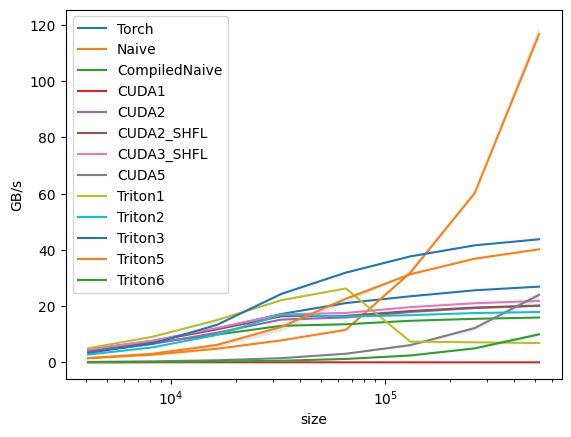

softmax-performance:
       size      Torch       Naive  CompiledNaive     CUDA1      CUDA2  CUDA2_SHFL  CUDA3_SHFL      CUDA5    Triton1    Triton2    Triton3    Triton5   Triton6
0    4096.0   4.591928    1.510325       4.302521  0.070022   3.806691    4.432900    4.571429   0.200548   5.044335   2.797814   3.413333   1.563359  0.077306
1    8192.0   7.670412    2.748993       6.942373  0.070425   6.585209    7.501831    7.757576   0.400822   9.142857   5.375328   6.714754   3.098336  0.155890
2   16384.0  12.011730    4.876191       9.917676  0.070598  10.583979   11.770115   12.263473   0.794568  15.058823   9.822542  13.385621   6.253435  0.311081
3   32768.0  17.246315    7.869356      13.044586  0.070516  15.255121   16.416833   17.066667   1.540718  22.140541  16.960662  24.380953  12.641976  0.622918
4   65536.0  21.113403   11.603399      13.585406  0.059575  15.984390   16.582997   17.617205   3.105972  26.298554  16.334996  31.937621  22.661135  1.253558
5  131072.0  23.523

In [24]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(12, 20, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=list(kernels.keys()),  # Possible values for `line_arg`.
        line_names=list(kernels.keys()),  # Label name for the lines.
        # styles=[('blue', '-'), ('green', '-'), ('red', '-'), ('pink', '-'), ('yellow', '-'), ('black', '-'), ('orange', '-'), ('purple', '-'), ('cyan', '-'), ('gray', '-'), ('gray', '--')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='softmax-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def triton_softmax_benchmark(size, provider):
    x = torch.rand((1, size), device="cuda", dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    ms, min_ms, max_ms = triton.testing.do_bench(lambda: kernels[provider](x), quantiles=quantiles)
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

triton_softmax_benchmark.run(print_data=True, show_plots=True)

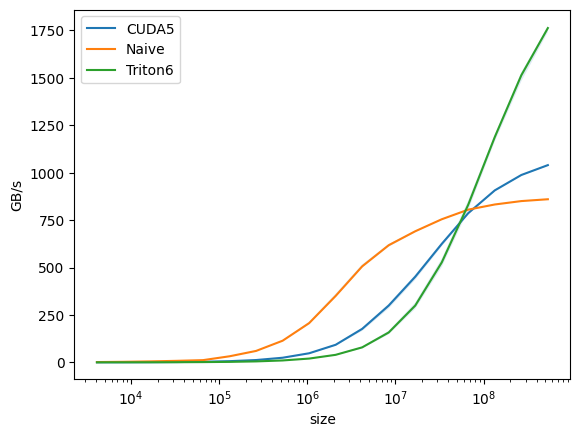

softmax-performance:
           size        CUDA5       Naive      Triton6
0        4096.0     0.197512    1.475504     0.076834
1        8192.0     0.397902    2.817056     0.155991
2       16384.0     0.791804    4.970874     0.309155
3       32768.0     1.545952    7.876923     0.620465
4       65536.0     3.083177   11.619858     1.233689
5      131072.0     6.142081   31.937621     2.464130
6      262144.0    12.145293   60.179980     4.931041
7      524288.0    24.241169  113.975650     9.902315
8     1048576.0    47.819046  206.738172    19.832350
9     2097152.0    92.556802  350.225787    39.598791
10    4194304.0   176.483381  506.069512    78.982829
11    8388608.0   299.400675  617.535922   157.491140
12   16777216.0   451.412996  691.102996   299.283177
13   33554432.0   624.547362  754.439090   526.856404
14   67108864.0   786.813144  805.203325   831.625640
15  134217728.0   906.852059  832.347682  1188.230153
16  268435456.0   987.853818  850.286500  1513.830521
17  536

In [25]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(12, 30, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=["CUDA5", "Naive", "Triton6"],  # Possible values for `line_arg`.
        line_names=["CUDA5", "Naive", "Triton6"],  # Label name for the lines.
        # styles=[('blue', '-'), ('green', '-'), ('red', '-'), ('pink', '-'), ('yellow', '-'), ('black', '-'), ('orange', '-'), ('purple', '-'), ('cyan', '-'), ('gray', '-'), ('gray', '--')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='softmax-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def triton_softmax_benchmark(size, provider):
    x = torch.rand((1, size), device="cuda", dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    ms, min_ms, max_ms = triton.testing.do_bench(lambda: kernels[provider](x), quantiles=quantiles)
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

triton_softmax_benchmark.run(print_data=True, show_plots=True)